# Homework 1: Data Matching

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from string2string.distance import LevenshteinEditDistance, JaccardIndex
from string2string.similarity import JaroSimilarity
from string2string.misc import Tokenizer
from sklearn.metrics import roc_curve, roc_auc_score

import nltk
from nltk.corpus import wordnet
import spacy

from itertools import chain
from collections import Counter
import re


# 1. Data

In [3]:
df = pd.read_csv('Amzon_Google.csv', sep=';', encoding='latin-1')
df

,Amazon,Google,Match
0,clickart 950 000 - premier image pack (dvd-rom),clickart 950000 - premier image pack (dvd-rom),1
1,noah's ark activity center (jewel case ages 3-8),the beginners bible: noah's ark activity cente...,1
2,peachtree by sage premium accounting for nonpr...,sage (ptree) - vernfp2007rt - premium accounti...,1
3,singing coach unlimited,singing coach unlimited - electronic learning ...,1
4,adobe after effects professional 6.5 upgrade f...,adobe software 22070152 after effects 6.5 pbupgrd,1
...,...,...,...
2595,shapes,aspyr media inc enemy territory: quake wars,0
2596,dragon naturally speaking standard v9,print shop deluxe 21,0
2597,mediarecover,sony media software acid pro 5 music productio...,0
2598,mediarecover,instant immersion italian 2.0,0


In [4]:
df['Match'].value_counts()

1    1300
0    1300
Name: Match, dtype: int64

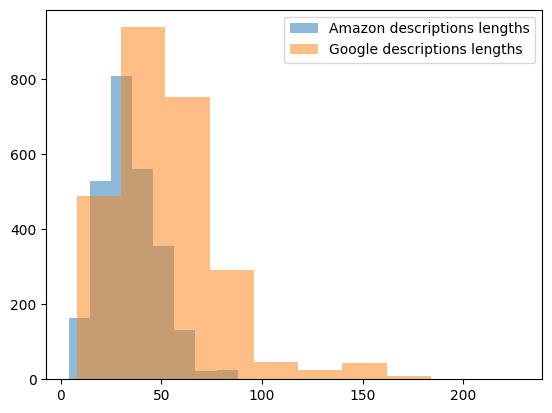

Amazon descriptions lengths average: 34.12
Google descriptions lengths average: 52.451153846153844


In [5]:
amazon_lens = []
google_lens = []

for i, row in df.iterrows():
    amazon_lens.append(len(row['Amazon']))
    google_lens.append(len(row['Google']))
    
plt.hist(amazon_lens, alpha=0.5, label='Amazon descriptions lengths')
plt.hist(google_lens, alpha=0.5, label='Google descriptions lengths')
plt.legend(loc='upper right')
plt.show()

print('Amazon descriptions lengths average:', np.mean(amazon_lens))
print('Google descriptions lengths average:', np.mean(google_lens))


# 2. Distance calculation

In [6]:
# We will store computed values in the new table
df_new = df[['Amazon', 'Google']].copy()

# Tokenizer instance for word-level distances/similarities only
tokenizer = Tokenizer(word_delimiter=' ')


### a) Levenshtain distance (character-level, normalized)

In [7]:
edit_distance = LevenshteinEditDistance()
df_new['Levenshtein distance (normalized)'] = df_new.apply(lambda x: edit_distance.compute(x['Amazon'], x['Google']) \
                                                    / max(len(x['Amazon']), len(x['Google'])), axis=1)


### b) Jaccard distance (word-level)

In [8]:
jaccard_distance = JaccardIndex()
df_new['Jaccard distance'] = df_new.apply(lambda x: jaccard_distance.compute(tokenizer.tokenize(x['Amazon']), \
                                                                             tokenizer.tokenize(x['Google'])), axis=1)


### c) Jaro distance (character-level)
$$
distance = 1 - similarity
$$

In [9]:
jaro_similarity = JaroSimilarity()
df_new['Jaro distance (char-level)'] = df_new.apply(lambda x: 1 - jaro_similarity.compute(x['Amazon'], x['Google']), axis=1)


### d) Jaro distance (word-level)

In [10]:
df_new['Jaro distance (word-level)'] = df_new.apply(lambda x: 1 - jaro_similarity.compute(tokenizer.tokenize(x['Amazon']),\
                                                                                          tokenizer.tokenize(x['Google'])), axis=1)

# Appending initial Match column
df_new['Match'] = df['Match']

In [11]:
df_new.head()

,Amazon,Google,Levenshtein distance (normalized),Jaccard distance,Jaro distance (char-level),Jaro distance (word-level),Match
0,clickart 950 000 - premier image pack (dvd-rom),clickart 950000 - premier image pack (dvd-rom),0.021277,0.333333,0.086802,0.130952,1
1,noah's ark activity center (jewel case ages 3-8),the beginners bible: noah's ark activity cente...,0.640625,0.666667,0.362756,0.430556,1
2,peachtree by sage premium accounting for nonpr...,sage (ptree) - vernfp2007rt - premium accounti...,0.338235,0.454545,0.269958,0.216667,1
3,singing coach unlimited,singing coach unlimited - electronic learning ...,0.574074,0.571429,0.191358,0.190476,1
4,adobe after effects professional 6.5 upgrade f...,adobe software 22070152 after effects 6.5 pbupgrd,0.783784,0.666667,0.353890,0.342857,1


# 3. ROCs visualization

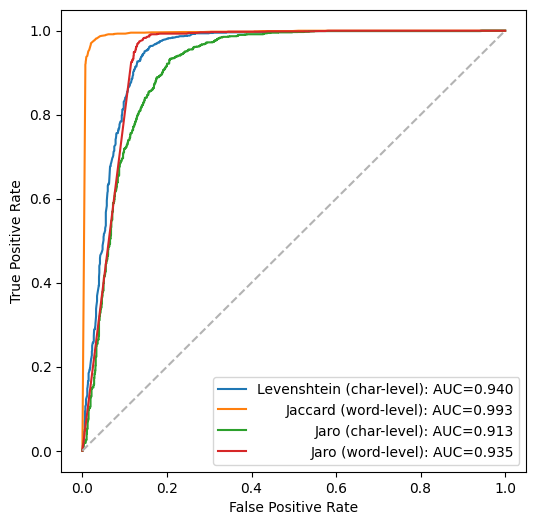

Levenshtein ROC AUC score:	 0.9396633136094674
Jaccard ROC AUC score:		 0.9934816568047338
Jaro (char-level) ROC AUC score: 0.9130097633136095
Jaro (word-level) ROC AUC score: 0.9350946745562131


In [12]:
y_true = df_new['Match'].values

y_pred_lev = df_new['Levenshtein distance (normalized)'].values
y_pred_jac = df_new['Jaccard distance'].values
y_pred_jar_cl = df_new['Jaro distance (char-level)'].values
y_pred_jar_wl = df_new['Jaro distance (word-level)'].values

# ROC values
fpr_lev, tpr_lev, _ = roc_curve(y_true, y_pred_lev, pos_label=0)
fpr_jac, tpr_jac, _ = roc_curve(y_true, y_pred_jac, pos_label=0)
fpr_jar_cl, tpr_jar_cl, _ = roc_curve(y_true, y_pred_jar_cl, pos_label=0)
fpr_jar_wl, tpr_jar_wl, _ = roc_curve(y_true, y_pred_jar_wl, pos_label=0)


# AUC score
# as roc_auc_score function does not have pos_label parameter, we will invert the y_true array instead
# distance~0 <==> match=1 (mostly)
auc_lev = roc_auc_score(np.logical_not(y_true).astype(int), y_pred_lev)
auc_jac = roc_auc_score(np.logical_not(y_true).astype(int), y_pred_jac)
auc_jar_cl = roc_auc_score(np.logical_not(y_true).astype(int), y_pred_jar_cl)
auc_jar_wl = roc_auc_score(np.logical_not(y_true).astype(int), y_pred_jar_wl)


############ Plotting ############

plt.figure(figsize=(6,6))

plt.plot(fpr_lev, tpr_lev, label=f'Levenshtein (char-level): AUC={auc_lev:.3f}')
plt.plot(fpr_jac, tpr_jac, label=f'Jaccard (word-level): AUC={auc_jac:.3f}')
plt.plot(fpr_jar_cl, tpr_jar_cl, label=f'Jaro (char-level): AUC={auc_jar_cl:.3f}')
plt.plot(fpr_jar_wl, tpr_jar_wl, label=f'Jaro (word-level): AUC={auc_jar_wl:.3f}')
plt.plot(fpr_lev, fpr_lev, color='0.7', linestyle='--')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

legend = plt.legend()
max_shift = max([t.get_window_extent().width for t in legend.get_texts()])
for t in legend.get_texts():
    t.set_ha('right')  # ha is alias for horizontalalignment
    temp_shift = max_shift - t.get_window_extent().width
    t.set_position((temp_shift, 0))    
plt.show()

print('Levenshtein ROC AUC score:\t', auc_lev)
print('Jaccard ROC AUC score:\t\t', auc_jac)
print('Jaro (char-level) ROC AUC score:', auc_jar_cl)
print('Jaro (word-level) ROC AUC score:', auc_jar_wl)



# 6. Results

Descibed in the report.

# 7. Improving results with string pre-processing

### a) Suggestion 1

String pre-processing workflow (in order):
* removing non-alphanumeric characters
* removing whitespacing between numbers
* lemmatization of words
* removing duplicate words
* ordering words in alphabetical order, putting numbers at the beginning


In [13]:
def remove_duplicates(s):
    s = s.split(" ")
    UniqueWords = Counter(s)
    res = " ".join(UniqueWords.keys())
    return res

def lemmatize_str(s):
    nlp_str = nlp(s)
    res = ''
    for token in nlp_str:
        res += token.lemma_ + ' '
    res = re.sub(' +', ' ', res)
    return res.strip()

def order_string_by_alphabet(s):
    words = [word for word in s.split()]
    words.sort()
    res = ' '.join(map(str, words))
    return res


nlp = spacy.load('en_core_web_sm')  # for lemmatization


In [14]:
df_new = df[['Amazon', 'Google']].copy()

# 1. removing non-alphanumeric characters
df_new['Amazon'] = df_new['Amazon'].str.replace('\W+', ' ', regex=True)
df_new['Google'] = df_new['Google'].str.replace('\W+', ' ', regex=True)
print('Non-alphanumeric words are removed')

# 2. removing whitespacing within/between numbers (950 000 -> 950000)
df_new['Amazon'] = df_new['Amazon'].str.replace(r'(\d)\s+(\d)', r'\1\2', regex=True)
df_new['Google'] = df_new['Google'].str.replace(r'(\d)\s+(\d)', r'\1\2', regex=True)
print('Whitespaces within/between numbers are removed')

# 3. string lemmatization (takes several seconds)
df_new['Amazon'] = df_new['Amazon'].apply(lemmatize_str)
df_new['Google'] = df_new['Google'].apply(lemmatize_str)
print('Words are lemmatized')

# 4. removing duplicate words in a string
df_new['Amazon'] = df_new['Amazon'].apply(remove_duplicates)
df_new['Google'] = df_new['Google'].apply(remove_duplicates)
print('Duplicate words are removed')

# 5. ordering words by alphabetical order (numbers are put at the beginning of strings)
df_new['Amazon'] = df_new['Amazon'].apply(order_string_by_alphabet)
df_new['Google'] = df_new['Google'].apply(order_string_by_alphabet)
print('Words are sorted')


Non-alphanumeric words are removed
Whitespaces within/between numbers are removed
Words are lemmatized
Duplicate words are removed
Words are sorted


In [15]:
edit_distance = LevenshteinEditDistance()
df_new['Levenshtein distance (normalized)'] = df_new.apply(lambda x: edit_distance.compute(x['Amazon'], x['Google']) \
                                                    / max(len(x['Amazon']), len(x['Google'])), axis=1)

jaccard_distance = JaccardIndex()
df_new['Jaccard distance'] = df_new.apply(lambda x: jaccard_distance.compute(tokenizer.tokenize(x['Amazon']), \
                                                                             tokenizer.tokenize(x['Google'])), axis=1)

jaro_similarity = JaroSimilarity()
df_new['Jaro distance (char-level)'] = df_new.apply(lambda x: 1 - jaro_similarity.compute(x['Amazon'], x['Google']), axis=1)

df_new['Jaro distance (word-level)'] = df_new.apply(lambda x: 1 - jaro_similarity.compute(tokenizer.tokenize(x['Amazon']),\
                                                                                          tokenizer.tokenize(x['Google'])), axis=1)
# Appending initial Match column
df_new['Match'] = df['Match']


In [16]:
df_new.head()

,Amazon,Google,Levenshtein distance (normalized),Jaccard distance,Jaro distance (char-level),Jaro distance (word-level),Match
0,950000 clickart dvd image pack premier rom,950000 clickart dvd image pack premier rom,0.000000,0.000000,0.000000,0.000000,1
1,38 activity age ark case center jewel noah s,activity ark beginner bible center noah s the,0.577778,0.583333,0.294637,0.273148,1
2,2007 account by for nonprofit peachtree premiu...,2007 account for nonprofit premium ptree sage ...,0.448276,0.400000,0.201653,0.166667,1
3,coach singe unlimited,coach electronic learning product singe unlimited,0.571429,0.500000,0.341091,0.500000,1
4,65 adobe after effect from professional standa...,22070152 65 adobe after effect pbupgrd software,0.661017,0.666667,0.348369,0.328042,1


Levenshtein ROC AUC score:	 0.9614846153846154
Jaccard ROC AUC score:		 0.9941331360946746
Jaro (char-level) ROC AUC score: 0.9351053254437871
Jaro (word-level) ROC AUC score: 0.9716366863905326


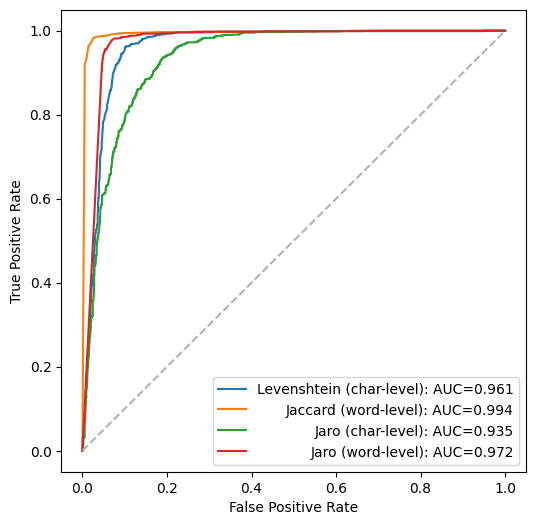

In [17]:
y_true = df_new['Match'].values

y_pred_lev = df_new['Levenshtein distance (normalized)'].values
y_pred_jac = df_new['Jaccard distance'].values
y_pred_jar_cl = df_new['Jaro distance (char-level)'].values
y_pred_jar_wl = df_new['Jaro distance (word-level)'].values

# ROC values
fpr_lev, tpr_lev, _ = roc_curve(y_true, y_pred_lev, pos_label=0)
fpr_jac, tpr_jac, _ = roc_curve(y_true, y_pred_jac, pos_label=0)
fpr_jar_cl, tpr_jar_cl, _ = roc_curve(y_true, y_pred_jar_cl, pos_label=0)
fpr_jar_wl, tpr_jar_wl, _ = roc_curve(y_true, y_pred_jar_wl, pos_label=0)


# AUC score
auc_lev = roc_auc_score(np.logical_not(y_true).astype(int), y_pred_lev)
auc_jac = roc_auc_score(np.logical_not(y_true).astype(int), y_pred_jac)
auc_jar_cl = roc_auc_score(np.logical_not(y_true).astype(int), y_pred_jar_cl)
auc_jar_wl = roc_auc_score(np.logical_not(y_true).astype(int), y_pred_jar_wl)


############ Plotting ############

plt.figure(figsize=(6,6))

plt.plot(fpr_lev, tpr_lev, label=f'Levenshtein (char-level): AUC={auc_lev:.3f}')
plt.plot(fpr_jac, tpr_jac, label=f'Jaccard (word-level): AUC={auc_jac:.3f}')
plt.plot(fpr_jar_cl, tpr_jar_cl, label=f'Jaro (char-level): AUC={auc_jar_cl:.3f}')
plt.plot(fpr_jar_wl, tpr_jar_wl, label=f'Jaro (word-level): AUC={auc_jar_wl:.3f}')
plt.plot(fpr_lev, fpr_lev, color='0.7', linestyle='--')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

legend = plt.legend()
max_shift = max([t.get_window_extent().width for t in legend.get_texts()])
for t in legend.get_texts():
    t.set_ha('right')  # ha is alias for horizontalalignment
    temp_shift = max_shift - t.get_window_extent().width
    t.set_position((temp_shift, 0))    

print('Levenshtein ROC AUC score:\t', auc_lev)
print('Jaccard ROC AUC score:\t\t', auc_jac)
print('Jaro (char-level) ROC AUC score:', auc_jar_cl)
print('Jaro (word-level) ROC AUC score:', auc_jar_wl)



### b) Suggestion 2: Improving <ins>word-level Jaro distance</ins> results using <span style="color:purple">WordNet</span>.

In [18]:
nltk.download('wordnet')

def add_syns(word):
    """ Forming a string of synonyms (synsets) from a given word """
    synonyms = wordnet.synsets(word)
    synonyms = set(chain.from_iterable([word.lemma_names() for word in synonyms]))
    appended_text = ''
    for syn in synonyms:
        appended_text = appended_text + ' ' + syn + ' '
    return appended_text

def add_syns_str(s):
    """ Forming a new string, consisting of synsets of the initial words """
    res = s
    for word in s.split(' '):
        res = res + add_syns(word) + ' '
    return res.lower().strip()


[nltk_data] Downloading package wordnet to /home/batyr/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Besides addition of synsets, we leave only one pre-processing step from all steps in the first variant, as it showed best results (from multiple experiments).

In [19]:
df_new = df[['Amazon', 'Google']].copy()

# 1. populating string with wordnet synonyms for each word
df_new['Amazon'] = df_new['Amazon'].apply(add_syns_str)
df_new['Google'] = df_new['Google'].apply(add_syns_str)
print('Wordnet synonyms are added')

# 2. removing non-alphanumeric characters
df_new['Amazon'] = df_new['Amazon'].str.replace('\W+', ' ', regex=True)
df_new['Google'] = df_new['Google'].str.replace('\W+', ' ', regex=True)
print('Non-alphanumeric words are removed')


Wordnet synonyms are added
Non-alphanumeric words are removed


After the new operation, *character-level* distance results are much worse and their calculation demands some time for the new populated strings.

In [20]:
# Uncomment
# edit_distance = LevenshteinEditDistance()
# df_new['Levenshtein distance (normalized)'] = df_new.apply(lambda x: edit_distance.compute(x['Amazon'], x['Google']) \
#                                                     / max(len(x['Amazon']), len(x['Google'])), axis=1)

jaccard_distance = JaccardIndex()
df_new['Jaccard distance'] = df_new.apply(lambda x: jaccard_distance.compute(tokenizer.tokenize(x['Amazon']), \
                                                                             tokenizer.tokenize(x['Google'])), axis=1)

# jaro_similarity = JaroSimilarity()
# df_new['Jaro distance (char-level)'] = df_new.apply(lambda x: 1 - jaro_similarity.compute(x['Amazon'], x['Google']), axis=1)

df_new['Jaro distance (word-level)'] = df_new.apply(lambda x: 1 - jaro_similarity.compute(tokenizer.tokenize(x['Amazon']),\
                                                                                          tokenizer.tokenize(x['Google'])), axis=1)
# Appending initial Match column
df_new['Match'] = df['Match']


In [21]:
df_new.head()

,Amazon,Google,Jaccard distance,Jaro distance (word-level),Match
0,clickart 950 000 premier image pack dvd rom pr...,clickart 950000 premier image pack dvd rom pre...,0.047619,0.015229,1
1,noah s ark activity center jewel case ages 3 8...,the beginners bible noah s ark activity center...,0.517544,0.296902,1
2,peachtree by sage premium accounting for nonpr...,sage ptree vernfp2007rt premium accounting for...,0.212121,0.074256,1
3,singing coach unlimited peach singe blab_out t...,singing coach unlimited electronic learning pr...,0.459770,0.148936,1
4,adobe after effects professional 6 5 upgrade f...,adobe software 22070152 after effects 6 5 pbup...,0.550000,0.251526,1


Jaccard ROC AUC score:		 0.9916127218934911
Jaro (word-level) ROC AUC score: 0.9900189349112425


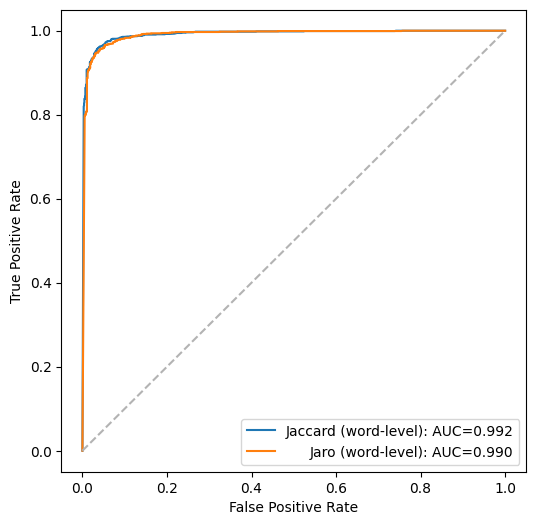

In [22]:
y_true = df_new['Match'].values

#y_pred_lev = df_new['Levenshtein distance (normalized)'].values
y_pred_jac = df_new['Jaccard distance'].values
#y_pred_jar_cl = df_new['Jaro distance (char-level)'].values
y_pred_jar_wl = df_new['Jaro distance (word-level)'].values

# ROC values
#fpr_lev, tpr_lev, _ = roc_curve(y_true, y_pred_lev, pos_label=0)
fpr_jac, tpr_jac, _ = roc_curve(y_true, y_pred_jac, pos_label=0)
#fpr_jar_cl, tpr_jar_cl, _ = roc_curve(y_true, y_pred_jar_cl, pos_label=0)
fpr_jar_wl, tpr_jar_wl, _ = roc_curve(y_true, y_pred_jar_wl, pos_label=0)


# AUC score
#auc_lev = roc_auc_score(np.logical_not(y_true).astype(int), y_pred_lev)
auc_jac = roc_auc_score(np.logical_not(y_true).astype(int), y_pred_jac)
#auc_jar_cl = roc_auc_score(np.logical_not(y_true).astype(int), y_pred_jar_cl)
auc_jar_wl = roc_auc_score(np.logical_not(y_true).astype(int), y_pred_jar_wl)


############ Plotting ############

plt.figure(figsize=(6,6))

#plt.plot(fpr_lev, tpr_lev, label=f'Levenshtein (char-level): AUC={auc_lev:.3f}')
plt.plot(fpr_jac, tpr_jac, label=f'Jaccard (word-level): AUC={auc_jac:.3f}')
#plt.plot(fpr_jar_cl, tpr_jar_cl, label=f'Jaro (char-level): AUC={auc_jar_cl:.3f}')
plt.plot(fpr_jar_wl, tpr_jar_wl, label=f'Jaro (word-level): AUC={auc_jar_wl:.3f}')
plt.plot(fpr_jar_wl, fpr_jar_wl, color='0.7', linestyle='--')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

legend = plt.legend()
max_shift = max([t.get_window_extent().width for t in legend.get_texts()])
for t in legend.get_texts():
    t.set_ha('right')  # ha is alias for horizontalalignment
    temp_shift = max_shift - t.get_window_extent().width
    t.set_position((temp_shift, 0))    

#print('Levenshtein ROC AUC score:\t', auc_lev)
print('Jaccard ROC AUC score:\t\t', auc_jac)
#print('Jaro (char-level) ROC AUC score:', auc_jar_cl)
print('Jaro (word-level) ROC AUC score:', auc_jar_wl)



# 6. Combinations of distances

In [23]:
df_new = df[['Amazon', 'Google']].copy()

# 1. removing non-alphanumeric characters
df_new['Amazon'] = df_new['Amazon'].str.replace('\W+', ' ', regex=True)
df_new['Google'] = df_new['Google'].str.replace('\W+', ' ', regex=True)
print('Non-alphanumeric words are removed')

# 2. removing whitespacing within/between numbers (950 000 -> 950000)
df_new['Amazon'] = df_new['Amazon'].str.replace(r'(\d)\s+(\d)', r'\1\2', regex=True)
df_new['Google'] = df_new['Google'].str.replace(r'(\d)\s+(\d)', r'\1\2', regex=True)
print('Whitespaces within/between numbers are removed')

# 3. string lemmatization
df_new['Amazon'] = df_new['Amazon'].apply(lemmatize_str)
df_new['Google'] = df_new['Google'].apply(lemmatize_str)
print('Words are lemmatized')

# 4. removing duplicate words in a string
df_new['Amazon'] = df_new['Amazon'].apply(remove_duplicates)
df_new['Google'] = df_new['Google'].apply(remove_duplicates)
print('Duplicate words are removed')

# 5. ordering words by alphabetical order (numbers are put at the beginning of strings)
df_new['Amazon'] = df_new['Amazon'].apply(order_string_by_alphabet)
df_new['Google'] = df_new['Google'].apply(order_string_by_alphabet)
print('Words are sorted')


Non-alphanumeric words are removed
Whitespaces within/between numbers are removed
Words are lemmatized
Duplicate words are removed
Words are sorted


In [24]:
edit_distance = LevenshteinEditDistance()
df_new['Levenshtein distance (normalized)'] = df_new.apply(lambda x: edit_distance.compute(x['Amazon'], x['Google']) \
                                                    / max(len(x['Amazon']), len(x['Google'])), axis=1)

jaccard_distance = JaccardIndex()
df_new['Jaccard distance'] = df_new.apply(lambda x: jaccard_distance.compute(tokenizer.tokenize(x['Amazon']), \
                                                                             tokenizer.tokenize(x['Google'])), axis=1)

jaro_similarity = JaroSimilarity()
df_new['Jaro distance (char-level)'] = df_new.apply(lambda x: 1 - jaro_similarity.compute(x['Amazon'], x['Google']), axis=1)

df_new['Jaro distance (word-level)'] = df_new.apply(lambda x: 1 - jaro_similarity.compute(tokenizer.tokenize(x['Amazon']),\
                                                                                          tokenizer.tokenize(x['Google'])), axis=1)
# Appending initial Match column
df_new['Match'] = df['Match']


In [25]:
df_new.head()

,Amazon,Google,Levenshtein distance (normalized),Jaccard distance,Jaro distance (char-level),Jaro distance (word-level),Match
0,950000 clickart dvd image pack premier rom,950000 clickart dvd image pack premier rom,0.000000,0.000000,0.000000,0.000000,1
1,38 activity age ark case center jewel noah s,activity ark beginner bible center noah s the,0.577778,0.583333,0.294637,0.273148,1
2,2007 account by for nonprofit peachtree premiu...,2007 account for nonprofit premium ptree sage ...,0.448276,0.400000,0.201653,0.166667,1
3,coach singe unlimited,coach electronic learning product singe unlimited,0.571429,0.500000,0.341091,0.500000,1
4,65 adobe after effect from professional standa...,22070152 65 adobe after effect pbupgrd software,0.661017,0.666667,0.348369,0.328042,1


In [26]:
df_new['Levenshtein/Jaccard'] = 0.2*df_new['Levenshtein distance (normalized)'] + 0.8*df_new['Jaccard distance']

# df_new['Levenshtein/Jaccard'] = 2 * df_new['Levenshtein distance (normalized)'] * df_new['Jaccard distance'] / (df_new['Levenshtein distance (normalized)'] + df_new['Jaccard distance'])
# df_new['Levenshtein/Jaccard'] = df_new['Levenshtein/Jaccard'].fillna(0.000001)

# df_new['Jaro(char)/Jaro(word)'] = 2 * df_new['Jaro distance (char-level)'] * df_new['Jaro distance (word-level)'] / (df_new['Jaro distance (char-level)'] + df_new['Jaro distance (word-level)'])
# df_new['Jaro(char)/Jaro(word)'].fillna(0.000001, inplace=True)

df_new['Jaro(char)/Jaro(word)'] = np.sqrt(df_new['Jaro distance (char-level)']*df_new['Jaro distance (word-level)'])


Levenshtein/Jaccard ROC AUC score (weighted sum) :	 0.9945115384615384
Jaro char/word comb ROC AUC score (geometric mean):	 0.9772701183431953


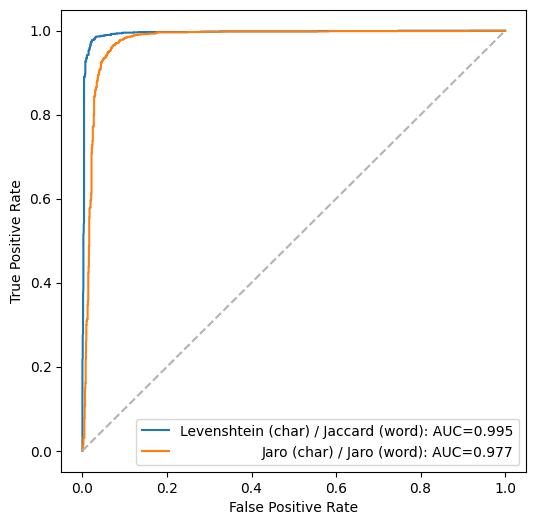

In [27]:
y_true = df_new['Match'].values

y_pred_lev_jac = df_new['Levenshtein/Jaccard'].values
y_pred_jar_comb = df_new['Jaro(char)/Jaro(word)'].values

fpr_lev_jac, tpr_lev_jac, _ = roc_curve(y_true, y_pred_lev_jac, pos_label=0)
fpr_jar_comb, tpr_jar_comb, _ = roc_curve(y_true, y_pred_jar_comb, pos_label=0)

auc_lev_jac = roc_auc_score(np.logical_not(y_true).astype(int), y_pred_lev_jac)
auc_jar_comb = roc_auc_score(np.logical_not(y_true).astype(int), y_pred_jar_comb)


############ Plotting ############

plt.figure(figsize=(6,6))

plt.plot(fpr_lev_jac, tpr_lev_jac, label=f'Levenshtein (char) / Jaccard (word): AUC={auc_lev_jac:.3f}')
plt.plot(fpr_jar_comb, tpr_jar_comb, label=f'Jaro (char) / Jaro (word): AUC={auc_jar_comb:.3f}')
plt.plot(fpr_lev_jac, fpr_lev_jac, color='0.7', linestyle='--')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

legend = plt.legend()
max_shift = max([t.get_window_extent().width for t in legend.get_texts()])
for t in legend.get_texts():
    t.set_ha('right')  # ha is alias for horizontalalignment
    temp_shift = max_shift - t.get_window_extent().width
    t.set_position((temp_shift, 0))    

print('Levenshtein/Jaccard ROC AUC score (weighted sum) :\t', auc_lev_jac)
print('Jaro char/word comb ROC AUC score (geometric mean):\t', auc_jar_comb)
